## Sparse Bayesian learning: Accelerated method

###### Assumptions: polynomial basis functions, scalar output, scalar input.
###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
random.seed(1306) # fixing the random seed

#### Problem definition

In [2]:
polyPower =  [0,1,2,3,4,5] # powers of polynomial
N = len(polyPower) # number of basis
alpha0 = np.exp([-10]*N) # Starting hyper-parameter value 
def basisFun(Xth,ith):
    return Xth**polyPower[ith]
rho0 = 100 # Starting error precision
rTol = 0.1 # 0-1, below this implies irrelevance
a = 1+rho0**2/1e-01 # prior for rho ~ gamma(a,b)
b = rho0/1e-01 # mean=a/b, var=a/b**2
Nsbl = 255 # number of SBL iterations (add 5 always)
trueKnown = 1 # 0 = dont plot true, 1= plot true 
CoeffTrue =[0]*N
CoeffTrue[0]=1
CoeffTrue[2]=1 
rhoTrue = 100

#### Load observations and generate design matrix

In [3]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,N))
for i in range(0,M):
    for j in range(0,N):
        Phi[i,j] = basisFun(Xobs[i],j)

#### Routine to update posterior statistics using Bayesian linear regression

In [4]:
def updateStat(alphai,rhoi):
    Ainv = np.diag(1/alphai)
    Bi = np.matmul(Phi,np.matmul(Ainv,np.transpose(Phi))) + np.identity(M)/rhoi
    Binvi = la.inv(Bi)
    Ki = np.matmul(Ainv,np.matmul(np.transpose(Phi),Binvi))
    Pi = Ainv - np.matmul(Ki,np.matmul(Phi,Ainv))
    mi = np.matmul(Ki,Yobs)
    PMLEinvi = rhoi*np.matmul(np.transpose(Phi),Phi)
    logEvidi = np.log(st.multivariate_normal.pdf(Yobs,[0]*M,Bi))
    gofi = st.multivariate_normal.pdf(Yobs,np.matmul(Phi,mi),np.identity(M)/rhoi) - 0.5*np.trace(np.matmul(PMLEinvi,Pi))
    return mi, Pi, logEvidi, Binvi, gofi

#### SBL accelerated algorithm

In [5]:
alpha = np.zeros((N,Nsbl));   r = np.zeros((N,Nsbl))
sbar = np.zeros((N,Nsbl));    qbar = np.zeros((N,Nsbl))
Wvar = np.zeros((N,Nsbl));    m = np.zeros((N,Nsbl))
s = np.zeros((N,Nsbl));       q = np.zeros((N,Nsbl))
logEvidSlope=np.zeros((N,Nsbl))
logEvid = [0]*Nsbl; gof = [0]*Nsbl
rho = [0]*Nsbl; sparsity = [0]*N
alpha[:,0] = alpha0;
rho[0] = rho0;
curList = list(range(N))
np.random.shuffle(curList)

In [6]:
for j in range(0,Nsbl-1):
    m[:,j], P, logEvid[j], Binv, gof[j] = updateStat(alpha[:,j],rho[j])
    Wvar[:,j] = np.diag(P)
    for ii in range(0,N):
        sbar[ii,j] = np.matmul(np.transpose(Phi[:,ii]),np.matmul(Binv,Phi[:,ii]))
        qbar[ii,j] = np.matmul(np.transpose(Phi[:,ii]),np.matmul(Binv,Yobs))
        s[ii,j] = sbar[ii,j]/(1-sbar[ii,j]/alpha[ii,j])
        q[ii,j] = qbar[ii,j]/(1-sbar[ii,j]/alpha[ii,j])
        logEvidSlope[ii,j] = (((s[ii,j]**2)/alpha[ii,j]) - \
                           q[ii,j]**2 + s[ii,j])/(2.0*(alpha[ii,j] + s[ii,j])**2)
        if alpha[ii,j] != np.inf:  
            r[ii,j] = 1 - alpha[ii,j]*Wvar[ii,j]
            sparsity[ii] = 1
        else:                      
            r[ii,j] = 0.0
            sparsity[ii] = 0
    i=j%N
    #if i == 0:  np.random.shuffle(curList)
    curi = curList[i]
    if q[curi,j]**2 > s[curi,j]:
        alpha[curi,j] = (s[curi,j]**2)/(q[curi,j]**2-s[curi,j])
        #print('Try: ',curList[i],' ; Add/update')
    else:
        alpha[curi,j] = np.inf
        #print('Try: ',curList[i],' ; remove/neglect')
    alpha[:,j+1] = alpha[:,j]
    rho[j+1] = (M - np.sum(r[:,j]) + 2*(a-1))/(np.power(la.norm(Yobs-np.matmul(Phi,m[:,j])),2) + 2*b)
np.savetxt('SBLfast_feval.dat',np.asarray(logEvid[:-1]))

In [7]:
print(' i    mean      var        prec     alpha  logalpha      r     logEvidSlope Sparse?')
for i in range(0,N):
    print("{0:2d}{1:10.2e}{2:10.2e}{3:10.2e}{4:10.2e}{5:10.3f}{6:10.2e}{7:12.2e}{8:5d}".format(\
        int(i),m[i,-2],Wvar[i,-2],1/Wvar[i,-2],alpha[i,-2],np.log(alpha[i,-2]),r[i,-2],logEvidSlope[i,-2],sparsity[i]))
print("\nLogEvid : {0:9.2f}\nRho: {1:14.2e}\nSparsity: {2:3d}/{3:3d}".format(\
    logEvid[-2],rho[-2],int(sum(sparsity)),N))
print(logEvid[0],np.log(alpha[:,0]))

 i    mean      var        prec     alpha  logalpha      r     logEvidSlope Sparse?
 0  9.52e-01  2.14e-03  4.68e+02  1.10e+00     0.097  9.98e-01   -1.20e-13    1
 1  5.56e-01  1.58e-02  6.34e+01  3.08e+00     1.124  9.51e-01   -3.46e-14    1
 2  0.00e+00  0.00e+00       inf       inf       inf  0.00e+00    0.00e+00    0
 3  0.00e+00  0.00e+00       inf       inf       inf  0.00e+00    0.00e+00    0
 4  5.95e-01  1.73e-02  5.79e+01  2.69e+00     0.991  9.54e-01   -3.16e-15    1
 5  0.00e+00  0.00e+00       inf       inf       inf  0.00e+00    0.00e+00    0
 6  0.00e+00  0.00e+00       inf       inf       inf  0.00e+00    0.00e+00    0
 7  0.00e+00  0.00e+00       inf       inf       inf  0.00e+00    0.00e+00    0

LogEvid :     13.45
Rho:       1.00e+02
Sparsity:   3/  8
-66.77872935572222 [5.         5.         5.         5.         5.         5.
 5.         2.24475639]


/home/rimple/Softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


#### Plot statistics over SBL iteration

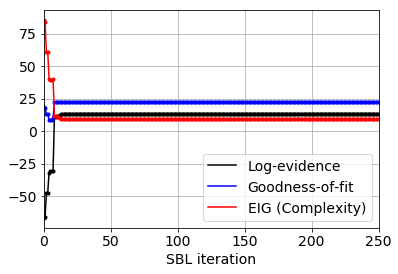

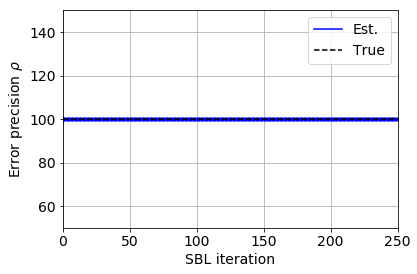

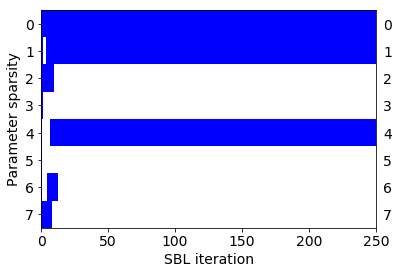

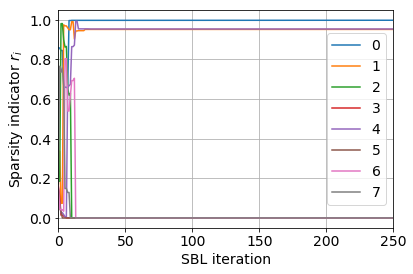

In [8]:
mpl.rcParams.update({'font.size':14})
plt.figure(1)
plt.plot(logEvid[:-1],'k.')
plt.plot(logEvid[:-1],'k-',label='Log-evidence')
plt.plot(np.log(gof[:-1]),'b.')
plt.plot(np.log(gof[:-1]),'b-',label='Goodness-of-fit')
plt.plot(np.log(gof[:-1]) - logEvid[:-1],'r.')
plt.plot(np.log(gof[:-1]) - logEvid[:-1],'r-',label='EIG (Complexity)')
#plt.legend(loc='best', numpoints = 1)
plt.legend(loc='lower right', numpoints = 1)
plt.grid(True)
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.savefig('figs/5_SBLfast_stat.eps',bbox_inches='tight')
plt.figure(2)
plt.plot(rho[:-1],'b.')
plt.plot(rho[:-1],'b-',label='Est.')
plt.plot([0,Nsbl],[rhoTrue,rhoTrue],'k--',label='True')
plt.legend(loc='best', numpoints = 1); plt.grid(True)
plt.xlim([0,Nsbl-5])
plt.ylim([rhoTrue-50,rhoTrue+50])
plt.ylabel(r'Error precision $\rho$')
plt.xlabel('SBL iteration');
plt.savefig('figs/5_SBLfast_rho.eps',bbox_inches='tight')
fig, ax = plt.subplots()
cmap = mpl.colors.ListedColormap(['white', 'blue'])
bounds = [0,rTol,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(r, cmap=cmap, aspect='auto',norm=norm)
ax.tick_params(labelright=True)
ax.set_yticks(np.arange(0, N, 1))
plt.xlim([0,Nsbl-5])
plt.ylabel('Parameter sparsity')
plt.xlabel('SBL iteration')
plt.savefig('figs/5_SBLfast_sparsity.eps',bbox_inches='tight')
plt.figure(8)
for i in range(0,N):
    plt.plot(r[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel(r'Sparsity indicator $r_i$')
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.legend(loc='center right', numpoints = 1)
plt.savefig('figs/5_SBLfast_r.eps',bbox_inches='tight')

#### Plot parameter marginal pdfs

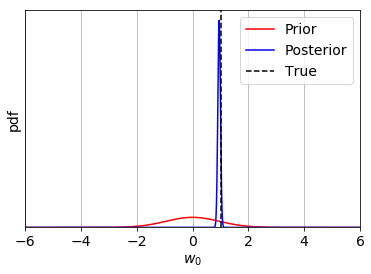

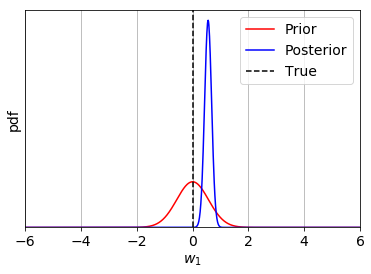

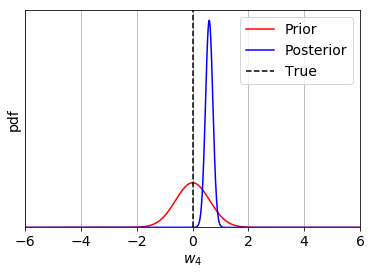

In [9]:
Wlim = [-6,6]  # xlim for plotting pdf plots
Ngrid = 1000  # density for grid generation in X
pscale=5  # for automatic bound calculation for pdf plots 
for i in range(0,N):
    if sparsity[i] == 1:
        Wpriormin = -pscale*np.sqrt(1/alpha[i,-2])
        Wpriormax = pscale*np.sqrt(1/alpha[i,-2])
        Wpostmin = m[i,-2]-pscale*np.sqrt(Wvar[i,-2])
        Wpostmax = m[i,-2]+pscale*np.sqrt(Wvar[i,-2])
        # comment this if using user supplied bounds Wlim
        #Wlim = [min(Wpriormin,Wpostmin),max(Wpostmax,Wpriormax)] 
        Wgrid  = np.linspace(Wlim[0],Wlim[1],Ngrid)
        Wpost  = st.multivariate_normal.pdf(Wgrid,m[i,-2],Wvar[i,-2])
        Wprior = st.multivariate_normal.pdf(Wgrid,0,1/alpha[i,-2])
        fig = plt.figure(i+1)
        plt.plot(Wgrid,Wprior,'r-',label='Prior')
        plt.plot(Wgrid,Wpost,'b-',label='Posterior')
        plt.grid(True)
        plt.yticks([])
        ax = plt.gca(); Ylim = ax.get_ylim()
        if trueKnown == 1: plt.plot([CoeffTrue[i],CoeffTrue[i]],[0,Ylim[1]],'k--',label='True')
        plt.ylim([0,Ylim[1]])
        plt.xlabel(r'$w_{'+str(i)+'}$')
        plt.ylabel('pdf')
        plt.xlim(Wlim[0],Wlim[1])
        plt.legend(loc='best', numpoints = 1)
        plt.savefig('figs/5_SBLfast_mpdf'+str(i)+'.eps',bbox_inches='tight')

#### Plot model predictions vs true model

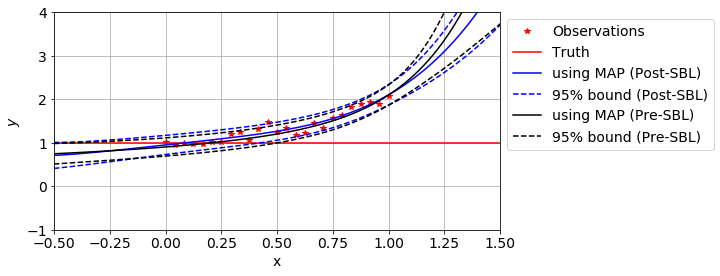

In [10]:
Xextra = 0.501 # width for extrapolation
Yrnge = [-1,4] 
Mnew = 100
Xrnge = [min(Xobs)-Xextra,max(Xobs)+Xextra]
Xnew = np.linspace(Xrnge[0],Xrnge[1],Mnew)
PhiNew = np.zeros((Mnew,N))
PhiNew0 = np.zeros((Mnew,N))
for i in range(0,Mnew):
    for j in range(0,N):
        PhiNew[i,j] = sparsity[j]*basisFun(Xnew[i],j)
        PhiNew0[i,j] = basisFun(Xnew[i],j)
Yvar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/rho[-1]
Ymean = np.matmul(PhiNew,m[:,-2])
m0,P0,logEvid0,Btmp,gof0 = updateStat(np.asarray(alpha0),rho0)
Yvar0 = np.matmul(PhiNew0,np.matmul(P0,np.transpose(PhiNew0))) + np.identity(Mnew)/rho0
Ymean0 = np.matmul(PhiNew0,m0)
fig = plt.figure(N+1,figsize=(8, 4))
ax = plt.subplot(111)
plt.plot(Xobs,Yobs,'r*',label='Observations')
if trueKnown ==1:
    Ytrue = np.matmul(PhiNew,np.transpose(CoeffTrue))
    plt.plot(Xnew,Ytrue,'r-',label='Truth')
plt.plot(Xnew,Ymean,'b-',label='using MAP (Post-SBL)')
plt.plot(Xnew,Ymean+2*np.sqrt(np.diag(Yvar)),'b--',label='95% bound (Post-SBL)')
plt.plot(Xnew,Ymean-2*np.sqrt(np.diag(Yvar)),'b--')
plt.plot(Xnew,Ymean0,'k-',label='using MAP (Pre-SBL)')
plt.plot(Xnew,Ymean0+2*np.sqrt(np.diag(Yvar0)),'k--',label='95% bound (Pre-SBL)')
plt.plot(Xnew,Ymean0-2*np.sqrt(np.diag(Yvar0)),'k--')
plt.grid(True)
plt.ylabel(r'$y$')
plt.xlabel('x')
plt.ylim(Yrnge)
plt.xlim([Xrnge[0],Xrnge[1]])
ax.legend(bbox_to_anchor=(1, 1))
#plt.legend(loc='best', numpoints = 1)
plt.savefig('figs/5_SBLfast_pred.eps',bbox_inches='tight')